# Pronóstico de Series Temporales / RNN - LSTM

# 1 Carga de Datos

In [ ]:
# Importamos las librerías a utilizar

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Cargamos el set de datos

df = pd.read_csv("/content/AirPassengers.csv")
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [ ]:
# Obtenemos una descripción de los datos

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


# 2 Preparación de los Datos

In [ ]:
# Convertimos la variable de objeto a fecha

df.Month = pd.to_datetime(df.Month)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       144 non-null    datetime64[ns]
 1   Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


In [ ]:
# Indexamos la columna de fecha y específicamos una frecuencia mensual

df = df.set_index("Month")
df.index.freq = 'MS'
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


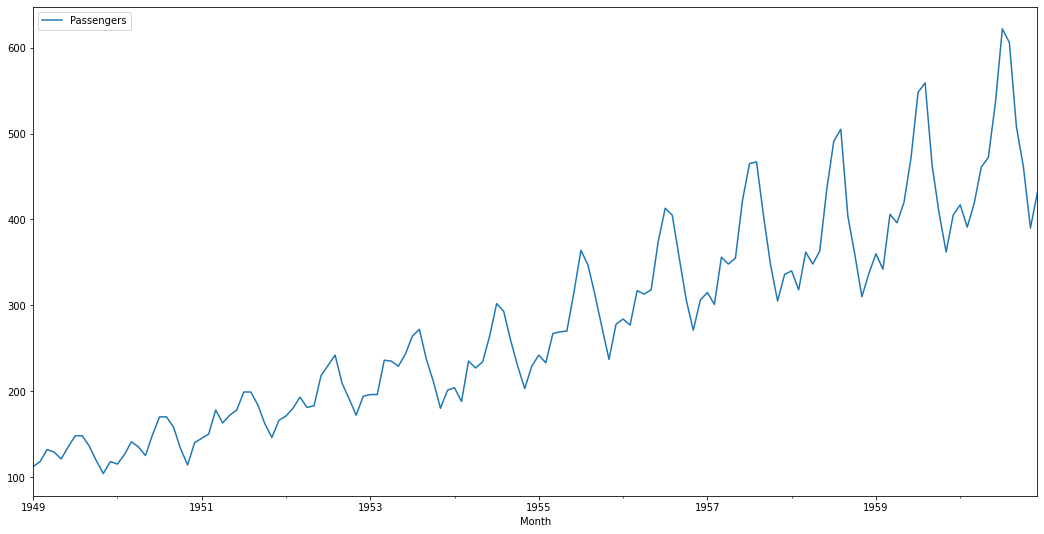

In [ ]:
# Graficamos los datos

df.plot(figsize=(18,9))
plt.show()

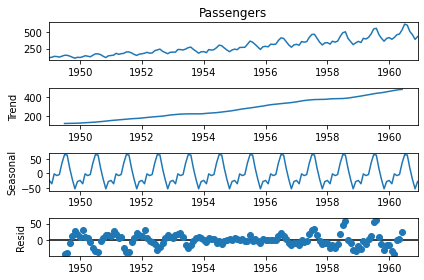

In [ ]:
# Graficamos los componentes de tendencia y estacionalidad 

from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(df['Passengers'])
decompose.plot(); 

In [ ]:
# Dividimos los datos de entrenamiento y prueba

train = df[:len(df)-12] # 12 meses
test = df[len(df)-12:]

print(train.shape)
print(test.shape)

(132, 1)
(12, 1)


In [ ]:
# Normalizamos los datos entre 0 y 1

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [ ]:
# Generamos la serie de tiempo

from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 12
n_features = 1

generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

# 3 Modelado de la Red

In [ ]:
# Definimos el modeleo LSTM

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))

In [ ]:
# Obtenemos un resumen del modelo

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compilamos el modelo

model.compile(
    loss='mse',
    optimizer='adam',
)

In [ ]:
# Ajustamos el modelo

historial = model.fit(generator, epochs=100, batch_size=1)

Epoch 1/100
120/120 [==============================] - 3s 6ms/step - loss: 0.0388
Epoch 2/100
120/120 [==============================] - 1s 6ms/step - loss: 0.0123
Epoch 3/100
120/120 [==============================] - 1s 6ms/step - loss: 0.0109
Epoch 4/100
120/120 [==============================] - 1s 6ms/step - loss: 0.0125
Epoch 5/100
120/120 [==============================] - 1s 6ms/step - loss: 0.0098
Epoch 6/100
120/120 [==============================] - 1s 6ms/step - loss: 0.0084
Epoch 7/100
120/120 [==============================] - 1s 5ms/step - loss: 0.0077
Epoch 8/100
120/120 [==============================] - 1s 5ms/step - loss: 0.0069
Epoch 9/100
120/120 [==============================] - 1s 5ms/step - loss: 0.0063
Epoch 10/100
120/120 [==============================] - 1s 5ms/step - loss: 0.0041
Epoch 11/100
120/120 [==============================] - 1s 6ms/step - loss: 0.0041
Epoch 12/100
120/120 [==============================] - 1s 5ms/step - loss: 0.0054
Epoch 13/100


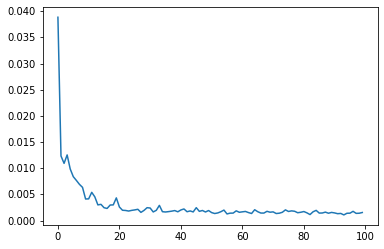

In [ ]:
# Graficamos la evolución de la pérdida en el modelo

plt.plot(historial.history['loss'])
plt.show()

In [ ]:
# Probamos las predicciones

last_train_batch = scaled_train[-12:]
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [ ]:
model.predict(last_train_batch)

array([[0.6590798]], dtype=float32)

In [ ]:
scaled_test[0]

array([0.68791209])

In [ ]:
# Realizamos las predicciones

test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
  # obtenemos la predicción del primer lote (batch)
  current_pred = model.predict(current_batch)[0]
  # agregamos la predicción en el arreglo (array)
  test_predictions.append(current_pred)
  # usamos la predicción para actualizar el lote y remover el primer valor
  current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

In [ ]:
# Invertimos el normalizado

true_predictions = scaler.inverse_transform(test_predictions)

In [ ]:
# Agregamos las predicciones al set de datos de prueba

test['Predictions'] = true_predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
test.head()

,Passengers,Predictions
Month,,
1960-01-01,417,403.881305
1960-02-01,391,399.471655
1960-03-01,419,430.942540
1960-04-01,461,445.065583
1960-05-01,472,471.526407


# 4 Evaluación del Modelo

In [ ]:
# Obtenemos las métricas del modelo

from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(test['Passengers'], test['Predictions']))
print(rmse)

14.272350821536754


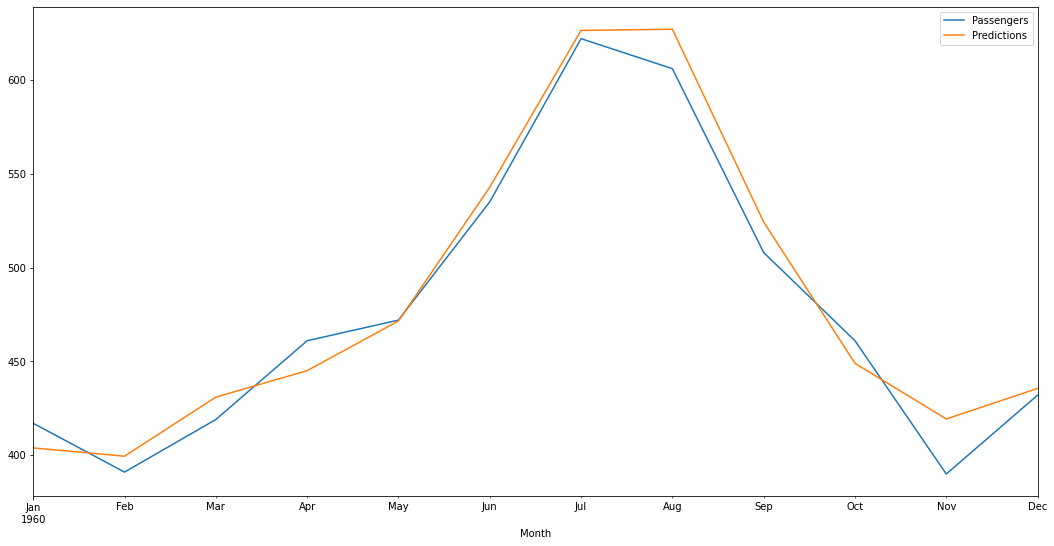

In [ ]:
# Graficamos las predicciones y los valores reales

test.plot(figsize=(18,9))
plt.show()